In [7]:
!pip install lime

In [8]:
import os
os.chdir("/home/hluf/Documents/Documents/week-three")

# Install Dependencies

In [ ]:
# --- Core Libraries ---
import numpy as np
import pandas as pd

# --- Scikit-Learn for modeling and interpretation ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay


# --- Post-Hoc Interpretation Libraries ---
import shap
import lime
import lime.lime_tabular

# --- Plotting ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Settings for better visualization ---
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 1: Load and Prepare the Data

We'll use the scikit-learn breast cancer dataset. It's a classic binary classification problem: predict whether a tumor is malignant or benign based on various measurements.

In [10]:
try:
    data_df = pd.read_csv("data/cleaned_insurance_data.csv")
    print("Data loaded successfully")
    
    print(f"Dataset shape: {data_df.shape}")
    print("\nMissing values:")
    print(data_df.isnull().sum())
    print("\nData types:")
    print(data_df.dtypes)
except FileNotFoundError:
    print("File not found")

/tmp/ipykernel_129396/2858877911.py:2: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv("data/cleaned_insurance_data.csv")


Data loaded successfully
Dataset shape: (1000098, 52)

Missing values:
UnderwrittenCoverID              0
PolicyID                         0
TransactionMonth                 0
IsVATRegistered                  0
Citizenship                      0
LegalType                        0
Title                            0
Language                         0
Bank                        145961
AccountType                  40232
MaritalStatus                 8259
Gender                        9536
Country                          0
Province                         0
PostalCode                       0
MainCrestaZone                   0
SubCrestaZone                    0
ItemType                         0
mmcode                         552
VehicleType                    552
RegistrationYear                 0
make                           552
Model                          552
Cylinders                      552
cubiccapacity                  552
kilowatts                      552
bodytype           

# 2: Intrinsic Interpretability (The "White Box" Models)
These models are simple enough to be understood directly.
## A) Logistic Regression Coefficients
The coefficients of a linear model tell us how the model relates each feature to the outcome.

<ipython-input-13-188017734>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


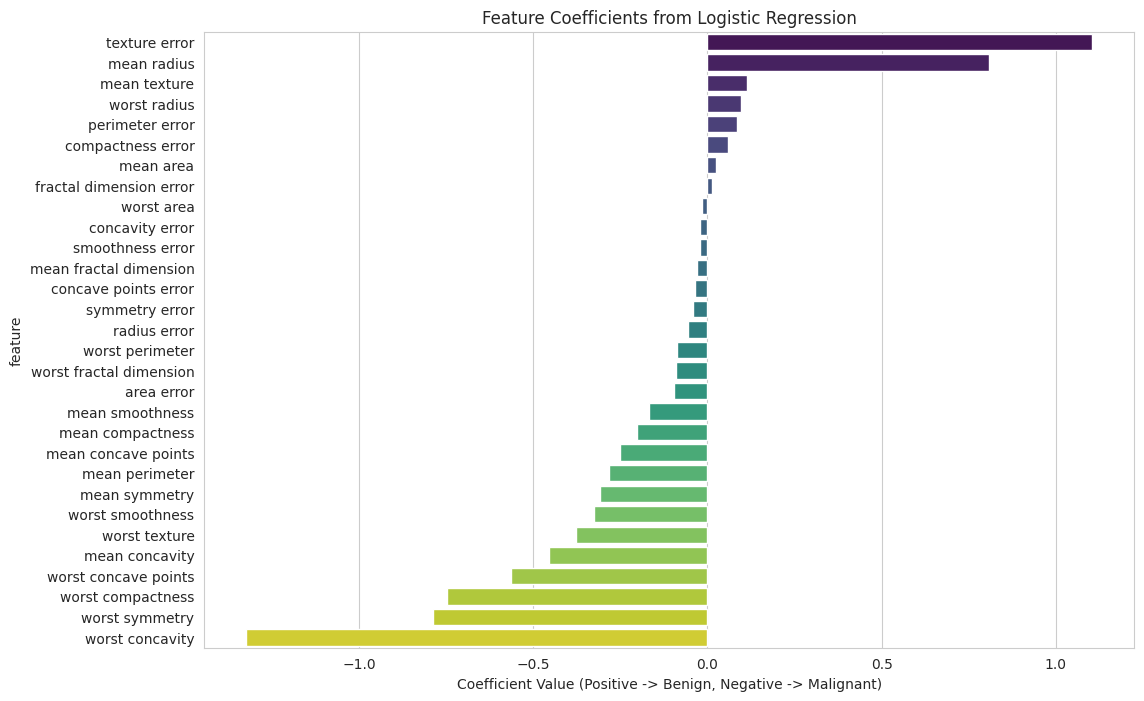

In [ ]:
# Train a simple logistic regression model
log_reg = LogisticRegression(max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

# Extract coefficients
coefficients = pd.DataFrame(
    {"feature": X.columns, "coefficient": log_reg.coef_[0]}
)
coefficients = coefficients.sort_values("coefficient", ascending=False)

# Plot the coefficients
plt.figure(figsize=(12, 8))
sns.barplot(
    x="coefficient", y="feature", data=coefficients, palette="viridis"
)
plt.title("Feature Coefficients from Logistic Regression")
plt.xlabel(
    "Coefficient Value (Positive -> Benign, Negative -> Malignant)"
)
plt.show()

Explanation: This plot shows the model's learned logic. Features with large positive coefficients strongly push the prediction towards "benign" (class 1). Features with large negative coefficients push it towards "malignant" (class 0).


---


## B) Decision Tree Path
A shallow decision tree is fully transparent. We can see the exact rules it uses.

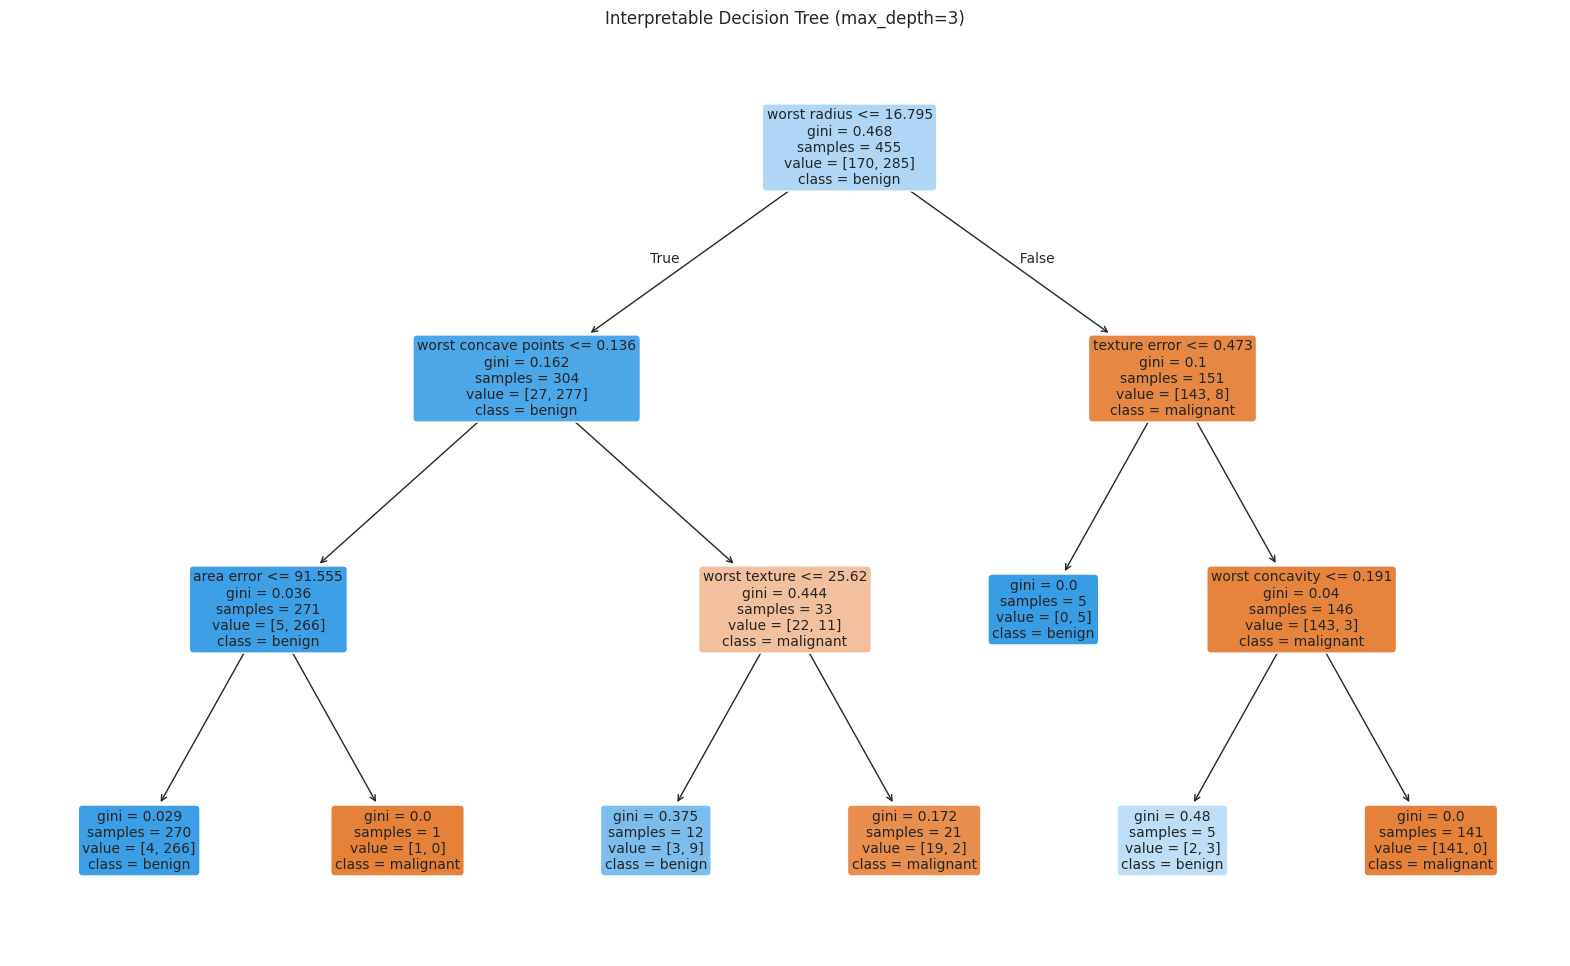

In [ ]:
# Train a shallow decision tree
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(20, 12))
plot_tree(
    tree_clf,
    feature_names=X.columns,
    class_names=cancer.target_names,
    filled=True,
    rounded=True,
    fontsize=10,
)
plt.title("Interpretable Decision Tree (max_depth=3)")
plt.show()

Explanation: You can trace any prediction down this tree. For example, a tumor with worst radius <= 16.8 and worst concave points <= 0.142 is classified as benign. This is a direct, human-readable explanation.


---


# 3: The Black Box Model (Gradient Boosting)
Now, let's train a more complex and powerful model. It will likely have higher accuracy, but we won't be able to interpret it just by looking at its parameters.

In [ ]:
# Train a Gradient Boosting Machine
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_clf.fit(X_train, y_train)

print(
    f"Logistic Regression Accuracy: {log_reg.score(X_test, y_test):.4f}"
)
print(f"Decision Tree Accuracy: {tree_clf.score(X_test, y_test):.4f}")
print(
    f"Gradient Boosting Accuracy: {gb_clf.score(X_test, y_test):.4f}"
)

Logistic Regression Accuracy: 0.9649
Decision Tree Accuracy: 0.9386
Gradient Boosting Accuracy: 0.9561


Explanation: The Gradient Boosting model has a good accuracy. But how does it work? We can't easily tell. This is the "black box" we need to investigate.


---


# 4: Global Post-Hoc Explanations
These methods explain the model's behavior on average.
## A) Permutation Feature Importance
Which features does the model rely on most across the entire test set?

<Figure size 1200x800 with 0 Axes>

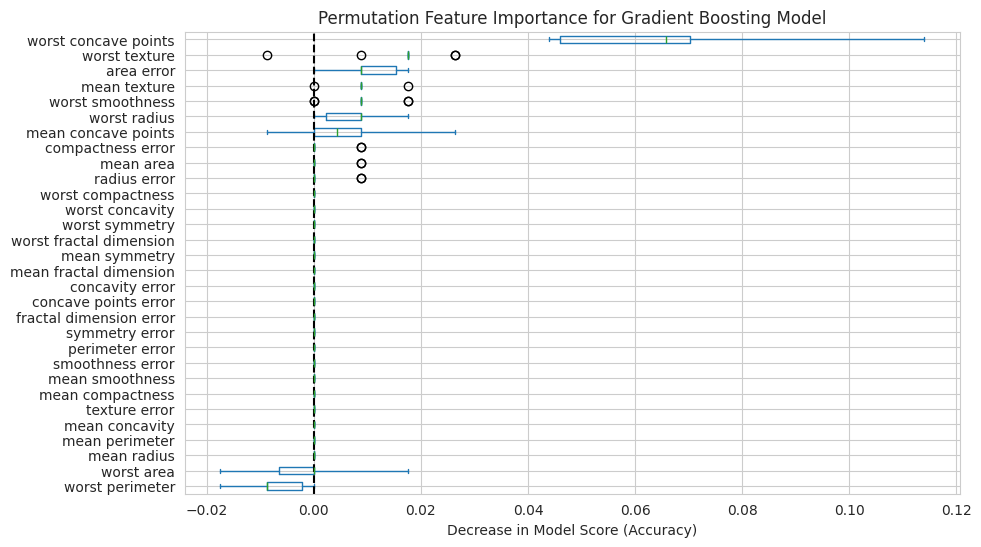

In [ ]:
# Calculate permutation importance
perm_importance = permutation_importance(
    gb_clf, X_test, y_test, n_repeats=10, random_state=42
)

# Organize results in a DataFrame
sorted_idx = perm_importance.importances_mean.argsort()
importance_df = pd.DataFrame(
    perm_importance.importances[sorted_idx].T,
    columns=X.columns[sorted_idx],
)

# Plot the results
plt.figure(figsize=(12, 8))
importance_df.plot(kind="box", vert=False, whis=10)
plt.title("Permutation Feature Importance for Gradient Boosting Model")
plt.xlabel("Decrease in Model Score (Accuracy)")
plt.axvline(x=0, color="k", linestyle="--")
plt.show()

Explanation: This plot shows how much the model's accuracy drops when a feature is shuffled. worst concave points and worst perimeter are clearly the most important features, as shuffling them hurts performance the most.


---


## B) Partial Dependence Plots (PDP)
How does the prediction change as we vary a single feature's value?

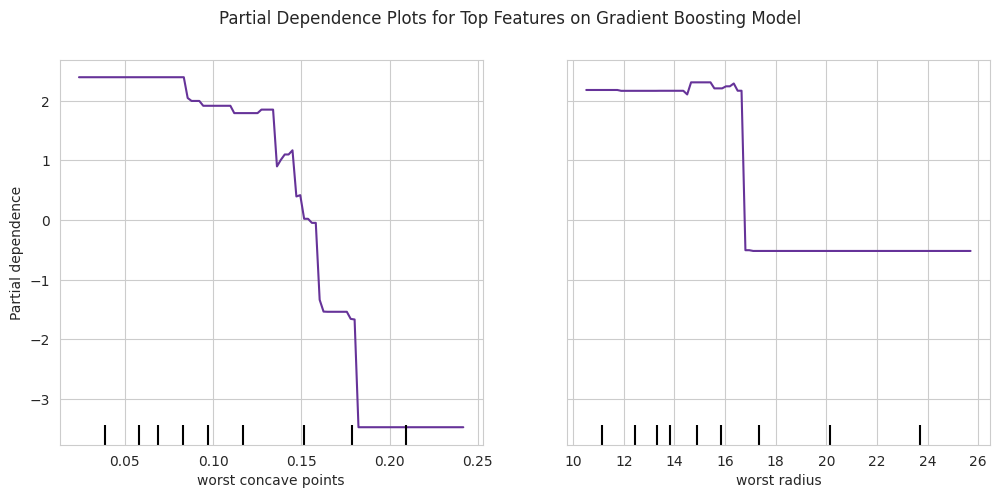

In [ ]:
# Create Partial Dependence Plots for the top 2 features
fig, ax = plt.subplots(figsize=(12, 5))
plt.suptitle(
    "Partial Dependence Plots for Top Features on Gradient Boosting Model"
)
features_to_plot = ["worst concave points", "worst radius"]
PartialDependenceDisplay.from_estimator(
    gb_clf,
    X_train,
    features_to_plot,
    ax=ax,
    line_kw={"color": "rebeccapurple"},
)
plt.show()

Explanation:

Worst Concave Points: As this value increases, the model's predicted probability of being benign (class 1) drops sharply.
Worst Radius: Similarly, as the radius of the tumor increases, the model becomes much more likely to predict "malignant" (a lower probability of being benign).


---


# 5: Local Post-Hoc Explanations
Why did the model make a specific decision for a single patient?
## A) SHAP (SHapley Additive exPlanations)
SHAP provides detailed breakdowns of individual predictions.

SHAP Summary Plot:


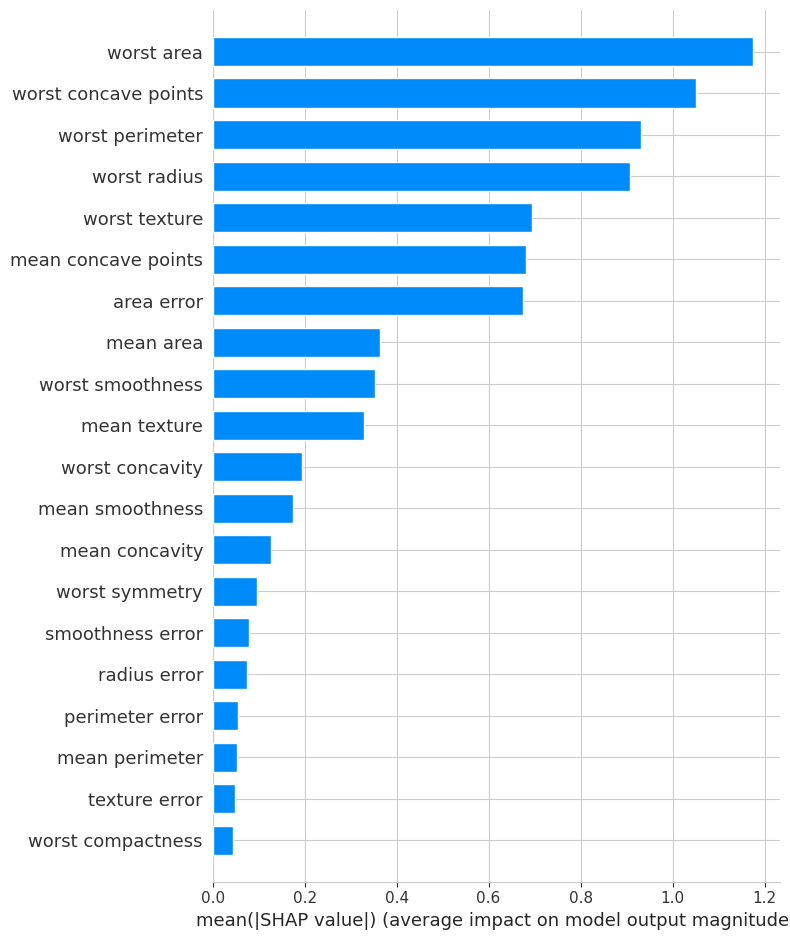

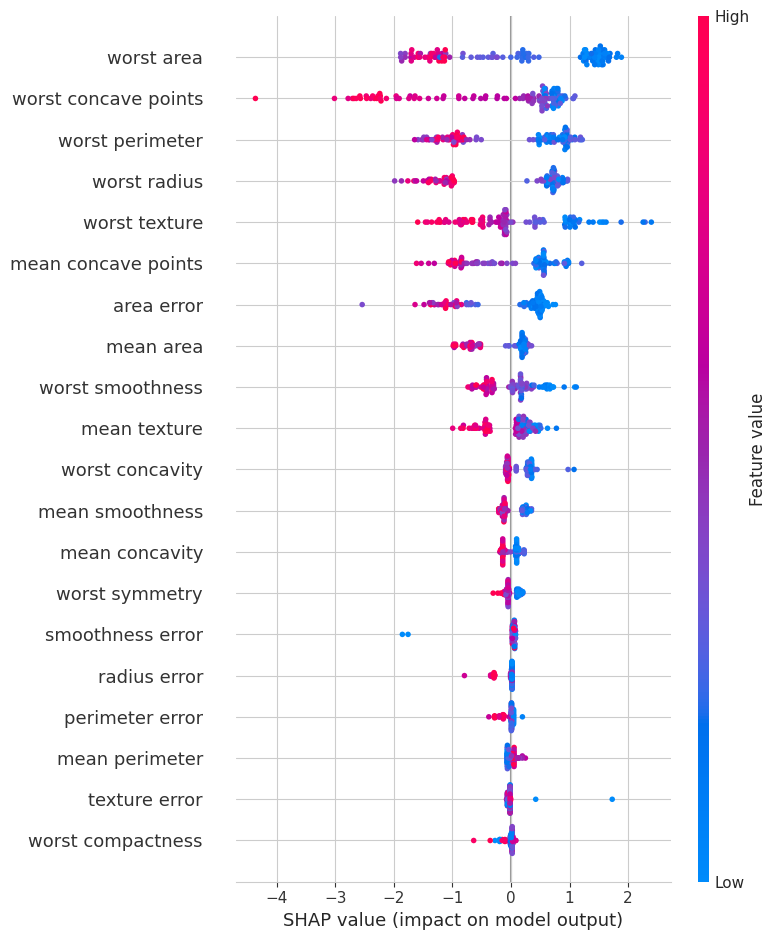


SHAP Force Plot for instance 0:
Model Prediction: malignant
Actual Label: malignant


In [ ]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(gb_clf)
shap_values = explainer.shap_values(X_test)

# --- Global summary using local values ---
print("SHAP Summary Plot:")
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

# --- Explain a single prediction ---
# Let's explain the first instance in the test set
instance_index = 0
print(f"\nSHAP Force Plot for instance {instance_index}:")
print(
    f"Model Prediction: {cancer.target_names[gb_clf.predict(X_test.iloc[[instance_index]])[0]]}"
)
print(f"Actual Label: {cancer.target_names[y_test[instance_index]]}")

# Initialize JS for plotting in notebook
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[instance_index, :],
    X_test.iloc[instance_index, :],
)

Explanation:

Summary Plots: The bar chart shows the average SHAP value magnitude, confirming our global feature importance. The dot plot shows not just importance but also the direction of the effect (e.g., high worst concave points values are red, pushing the prediction lower/malignant).
Force Plot: This is the explanation for one patient. The base value is the average prediction. Red arrows (worst radius, worst area) are features pushing the prediction towards malignant. Blue arrows (mean texture) are pushing it towards benign. The final prediction is the result of these competing forces.


---


## B) LIME (Local Interpretable Model-agnostic Explanations)
LIME creates a simple, local model to approximate the black box's behavior for one prediction.

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.


LIME Explanation for instance 0:


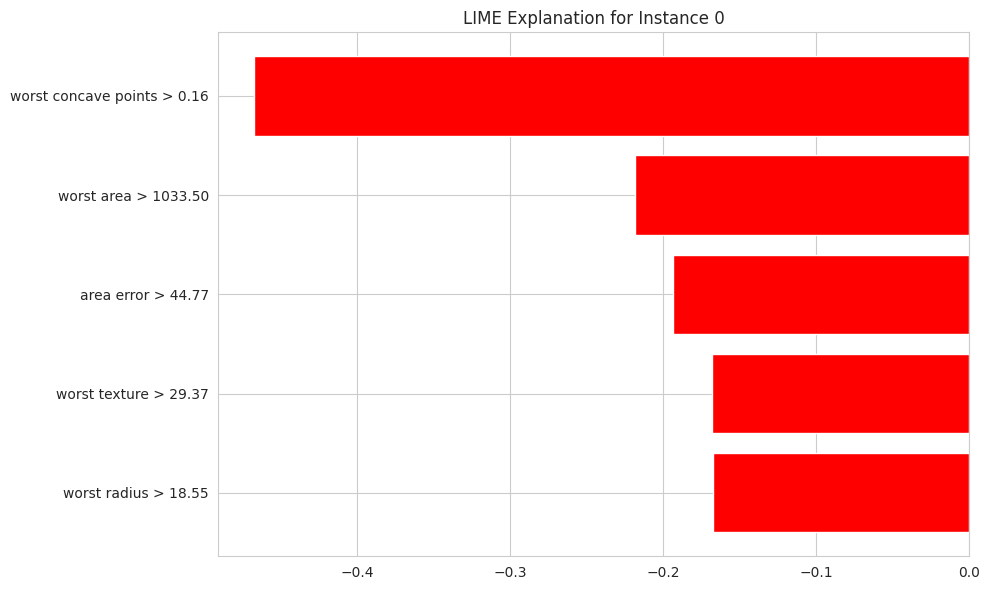

In [ ]:
# Initialize the LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=cancer.target_names,
    mode="classification",
)

# Explain the same instance as we did with SHAP
instance_index = 0
lime_exp = lime_explainer.explain_instance(
    data_row=X_test.iloc[instance_index],
    predict_fn=gb_clf.predict_proba,
    num_features=5,
)

print(f"\nLIME Explanation for instance {instance_index}:")
# Show the explanation as a plot
fig = lime_exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance {instance_index}")
plt.tight_layout()
plt.show()

Explanation: LIME provides a more focused, linear approximation. For this specific patient, it identifies that worst concave points > 0.15 was the strongest piece of evidence pushing the model to predict "malignant." It presents a simple, human-friendly list of the top contributing factors for this single decision.